![MCX Banner](https://mcx.space/img/mcx18_banner.png)

# » Getting Started with pmcx

- MCX Website: https://mcx.space
- License: GNU Public License V3 or later
- URL: https://pypi.org/project/pmcx/
- Github: https://github.com/fangq/mcx

Monte Carlo eXtreme (MCX) is a fast photon transport simulation software for 3D heterogeneous turbid media. By taking advantage of the massively parallel threads and extremely low memory latency in a modern graphics processing unit (GPU), MCX is capable of performing Monte Carlo (MC) photon simulations at a blazing speed, typically hundreds to a thousand times faster than a fully optimized CPU-based MC implementation.

## Step 0: install necessary Python modules

> Only need to run this once at the beginning


The only required dependency for `pmcx` is `numpy`. Additional (and optional) modules can be installed, including
- [`jdata`](https://pypi.org/project/jdata/), for saving simulations to human-readable JSON/[NeuroJSON](https://neurojson.org) files, also for importing MCX .jnii/.jdat/.jdt output files
- [`bjdata`](https://pypi.org/project/bjdata/), for saving simulations to more compact binary JSON files, also for importing MCX .bnii/.jdb output files
- [`matplotlib`](https://pypi.org/project/matplotlib/), for plotting and visualization of the data

If you intend to install pmcx on your local computer (assuming you have an NVIDIA GPU), please first install `python` and run the below `pip` command in a command line window.

In [ ]:
!pip install numpy pmcx jdata bjdata matplotlib

## Step 1: Import modules

---

> Only need to run this once at the beginning


In [2]:
import numpy as np
import pmcx
import jdata as jd
from matplotlib import pyplot as plt

pmcx.__version__   # print imported pmcx version number

'0.2.2'

## Step 2: Verify you have access to NVIDIA GPUs

---

If you run this on Google Colab, please go to menu **Edit\Notebook Settings\Hardware accelerator**, and select "GPU". By default, Colab does not enable GPU and the below command will fail.

In [3]:
pmcx.gpuinfo()

[{'name': 'Tesla T4',
  'id': 1,
  'devcount': 1,
  'major': 7,
  'minor': 5,
  'globalmem': 15835398144,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1590000,
  'sm': 40,
  'core': 2560,
  'autoblock': 64,
  'autothread': 81920,
  'maxgate': 0}]

## Step 3: Define simulation (as a dictionary variable)

---



In [4]:
cfg = {
       'nphoton': 1000000,
       'vol':np.ones([60,60,60],dtype='uint8'),
       'tstart':0,
       'tend':5e-9,
       'tstep':5e-9,
       'srcpos': [30,30,0],
       'srcdir':[0,0,1],
       'prop':[[0,0,1,1],[0.005,0.1,0.01,1.37]]
       }

##Step 4: Run pmcx simulation

---


In [ ]:
res = pmcx.mcxlab(cfg)
# or res=pmcx.run(cfg)

## Step 5: Visualize results

---

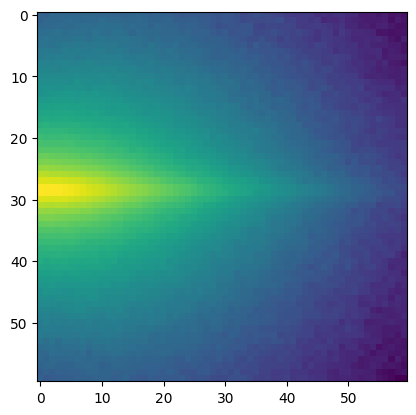

In [6]:
plt.imshow(np.log10(res['flux'][30,:, :]))
plt.show()

# » Customize how to run pmcx

## Use positional parameters

---

You can call `pmcx.run` in a more compact way (as a one-liner) by directly passing on each setting as a "positional parameter"

In [ ]:
res = pmcx.run(nphoton=1000000, vol=np.ones([60, 60, 60], dtype='uint8'),
               tstart=0, tend=5e-9, tstep=5e-9, srcpos=[30,30,0], srcdir=[0,0,1],
               prop=np.array([[0, 0, 1, 1], [0.005, 1, 0.01, 1.37]]))

res['flux'].shape

## Use itemized dictionary format

---

Alternatively, you can also be explicity and define each input field in separate lines. This provides better readability.

In [ ]:
cfg={}
cfg['nphoton']=1e7
cfg['vol']=np.ones([60, 60, 60], dtype='uint8')
cfg['vol'][20:40, 30:40, 20:30]=2
cfg['tstart']=0
cfg['tend']=5e-9
cfg['tstep']=5e-9
cfg['srcpos']=[30,30,0]
cfg['srcdir']=[0,0,1]
cfg['prop']=[[0, 0, 1, 1], [0.005, 1, 0.01, 1.37], [0.1, 10, 0.9, 1]]

res=pmcx.run(cfg)

res['stat']

When using a `dict` cfg input, it is recommended to call `pmcx.mcxlab(cfg)` instead of `pmcx.run()` because `pmcx.mcxlab()` contains the pre- and post-processing code to make the output `res` similar to those returned by `mcxlab()` in MATLAB/Octave.

Specificically, `pmcx.mcxlab()` further processes the `res['detp']` data into directionary with keys `{'detid', 'ppath', 'nscat', 'p', 'v', 'mom', 'iquv', 'w0'}` depends on `cfg['savedetflag']` and related input settings. In addition, `pmcx.mcxlab()` also process `res['traj']` trajectory data into directionary-formatted output for easy processing, including keys like `{'id', 'pos'}`. Please run `help(pmcx.mcxlab)` for more details.

In [ ]:
res=pmcx.mcxlab(cfg)
res.keys()

# » Import and export

## Export data to human-readable JSON/NeuroJSON formats for easy sharing

---
The US NIH-funded NeuroJSON Project (https://neurojson.org), also developed and led by MCX's author Dr. Fang, is aimed at breaking the barriers for sharing and reusing scientific data between diverse software and programming environments (such as MATLAB, Python, web etc). The NeuroJSON project envisons that the key for making valuable scientific data long-lasting and easily reusable is **human-readability**, thus has adopted JSON and binary JSON as the primary universal format to store data files. JSON is not only directly human-readable, but also directly supported across almost every programming language and software.

To read/write JSON/NeuroJSON encoded universal data files, one just need to install and import a tiny module called `jdata` (https://pypi.org/project/jdata/)

In [ ]:
import jdata as jd

Once you imported `jdata`, you can then call the `jdata.encode()` function to serialize arbitrary Python data structures, including lists, dicts, numpy arrays etc, into easy-to-parse JSON-like formats. The binary data is losslessly stored in JSON based annotations.

It is highly recommended to take advantage of the built-in data compression capability to save your data in a more compact format without losing precision. A compression codec can be pased by adding a key named `compression` in the 2nd parameter of `encode`. Supported compression methods include: `zlib`, `gzip`, `lzma`, `lz4` etc.

In [ ]:
jd.encode(res['flux'], {'compression':'zlib','base64':1})

Similarly, one can use `lzma` compression to achieve smaller output size at the costof longer compression time. One can compress any numpy array such as `cfg['vol']` to easy-to-exchange JSON data

In [ ]:
jd.encode(cfg['vol'], {'compression':'lzma','base64':1})

{'_ArrayType_': 'uint8',
 '_ArraySize_': [60, 60, 60],
 '_ArrayZipType_': 'lzma',
 '_ArrayZipSize_': [1, 216000],
 '_ArrayZipData_': b'XQAAgAD//////////wAA7/v//6O3/0c+SBVyOWFRuJIo5qOGB/nu5B6C0y/FOjwBS7F+yYqKTS+jDdl/puOMIxFT4FkYxXWK4nf4tpR/DGrA3nRJZOLpXFOyBNj3RAyrXw1tRunlw3aIt5ZXp4XZZkuf//9alAAA'}

JSON/`jdata` encoded JSON-formatted data can be readily decoded to losslessly restore the original data. One can call `jdata.decode()` to achieve this.

In [ ]:
newflux = jd.decode(jd.encode(res['flux'], {'compression':'zlib'}))

print([newflux.shape, newflux.dtype])

## Save mcx output data to JSON/NeuroJSON files

---

In [ ]:
jd.save(res['flux'], 'mcx_flux.json', {'compression':'zlib'})

## Download .json file to local disk

---

In [ ]:
from google.colab import files
files.download('mcx_flux.json')

# » Use detectors

## Setup detectors and detection flags

In [9]:
cfg['detpos']=[[30,27,0,1], [30,25,0,1]]   # to detect photons, one must first define detectors
cfg['issavedet']=1                         # cfg.issavedet must be set to 1 or True in order to save detected photons
cfg['issrcfrom0']=1                        # set this flag to ensure src/det coordinates align with voxel space
cfg.keys()

dict_keys(['nphoton', 'vol', 'tstart', 'tend', 'tstep', 'srcpos', 'srcdir', 'prop', 'detpos', 'issavedet', 'issrcfrom0'])

## Run simulation, detected photons are stored in `res['detp']`

In [ ]:
res=pmcx.mcxlab(cfg)
res['detp'].keys()

## Display histogram of partial-paths

---



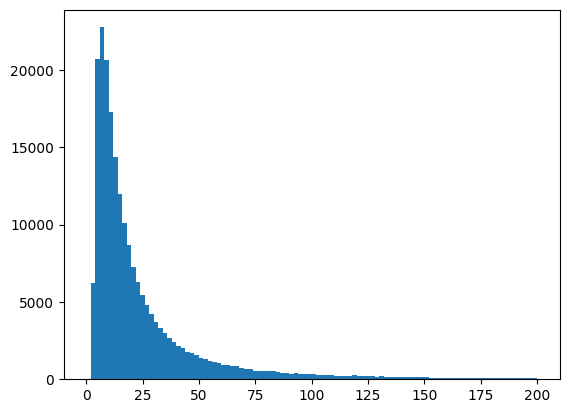

In [14]:
plt.hist(res['detp']['ppath'][:,0], bins=100, range=[0,200]);

## Use `savedetflag` to save multiple output data types

---
in the below example, we ask mcx to output detected photon specific data according to the letters presented in the `savedetflag` string:

- `d`: detected photon ID (starting from 1), width: 1
- `p`: partial path for each medium type, width: #media
- `x`: detected photon existing position, width: 3

other possible flags include
- `s`: partial scattering count per medium, width: #media
- `v`: existing direction vector, width: 3
- `m`: momentum transfer per medium, width: #media
- `w`: photon initial weight, width: 1

In [15]:
cfg['savedetflag']='dpx'

In [ ]:
res=pmcx.run(cfg)

res['detp'].shape

In this case, **it is recommended to call `pmcx.mcxlab(cfg)`** instead of `pmcx.run()` as the `pmcx.mcxlab` function splits the detected photon data into detailed named dictionary fields

In [ ]:
res=pmcx.mcxlab(cfg)

res['detp'].keys()

## Plot detected photon existing positions

---



In [ ]:
# plot photon existing position for Det#1 in red
plt.scatter(res['detp']['p'][res['detp']['detid']==1,0], res['detp']['p'][res['detp']['detid']==1,1],
            marker='.',color='red');

# plot photon existing position for Det#2 in blue
plt.scatter(res['detp']['p'][res['detp']['detid']==2,0], res['detp']['p'][res['detp']['detid']==2,1],
            marker='.',color='blue');
plt.axis('equal');

## Save both fluence and detected photon data to disk

---



In [ ]:
jd.save(res, 'mcx_flux_dept.json', {'compression':'zlib'})

## Download output file

---



In [ ]:
from google.colab import files
files.download('mcx_flux_dept.json')

# » Save diffuse reflectance

## Padding volume by zeros to save diffuse reflectance

---

mcx can accumulate a photon's remaining weight upon exiting the domain surface. The accumulated distribution can be used to compute "diffuse reflectance" (`dref`). However, mcx only accumulates `dref` in 0-valued voxels (i.e. background).

That means in order to save `dref` along any medium surface, one must pad a layer of zero voxels outside of this surface.

In the below example, we set voxels in z=0 plane to be 0s, so we can capture photons escaping from z=1 plane.

The saved "diffuse reflectance" are stored under the `dref` key of the output dictonary object.

In [ ]:
cfg['vol'][:,:,0]=0
cfg['issaveref']=1

res=pmcx.mcxlab(cfg)

res.keys()

In [ ]:
plt.imshow(np.log10(res['dref'][:, :, 0]))
plt.colorbar()
plt.show()

# » Photon replay

For details related to the "photon replay" algorithm, please check out our below paper:

* Ruoyang Yao, Xavier Intes, Qianqian Fang*, ["A direct approach to compute Jacobians for diffuse optical tomography using perturbation Monte Carlo-based photon 'replay',"](https://www.osapublishing.org/boe/abstract.cfm?uri=boe-9-10-4588) Biomed. Optics Express 9(10), 4588-4603, (2018)


## Using *photon replay* to build Jacobians

In [ ]:
# Step 1 - run baseline simulation to get detected photons (and their seeds) at detectors
cfg={}
cfg['nphoton']=1e7
cfg['vol']=np.ones([60, 60, 60], dtype='uint8')
cfg['vol'][20:40, 30:40, 20:30]=2
cfg['tstart']=0
cfg['tend']=5e-9
cfg['tstep']=5e-9
cfg['srcpos']=[30,30,0]
cfg['srcdir']=[0,0,1]
cfg['prop']=[[0, 0, 1, 1], [0.005, 1, 0.01, 1.37], [0.1, 10, 0.9, 1]]
cfg['detpos']=[[30,20,0,1]]        # to detect photons, one must first define detectors
cfg['issavedet']=1                 # cfg.issavedet must be set to 1 or True in order to save detected photons
cfg['issrcfrom0']=1                # set this flag to ensure src/det coordinates align with voxel space
cfg['issaveseed']=1   ##!important!# set this flag to store detected photon seed data

# run baseline simulation, now seed data are stored in res['seeds']]
res=pmcx.mcxlab(cfg)
res.keys()

In [27]:
# Step 2 - replay detected photon and output Jacobian
cfg_replay=cfg;
cfg_replay['seed']=res['seeds']        # one must define cfg['seed'] using the returned seeds
cfg_replay['detphotons']=res['detp']['data']   # one must define cfg['detphotons'] using the returned detp data
cfg_replay['outputtype']='jacobian'    # tell mcx to output absorption (μ_a) Jacobian

# run replay, if done properly, the exact the same set of photons will be "redetected"
res2=pmcx.mcxlab(cfg_replay)
res2.keys()
print({'redetection':res2['seeds'].shape, 'initial_detection':res['seeds'].shape})

nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
issrcfrom0: 1
srcpos: [30, 30, 0, 1]
srcdir: [0, 0, 1, 0]
issavedet: 1
issaveseed: 1
dict_keys(['seeds', 'detp', 'flux', 'stat'])
{'redetection': (16, 11217), 'initial_detection': (16, 11218)}


<ipython-input-28-0c9b4b641cc8>:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(res2['flux'][30,:, :]))


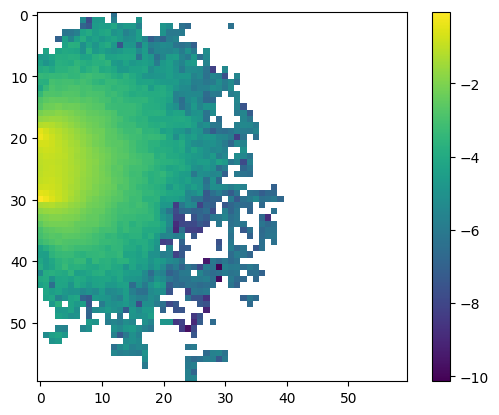

In [28]:
# plot μ_a Jacobian (sensitivity profile, or photon banana)
plt.imshow(np.log10(res2['flux'][30,:, :]))
plt.colorbar()
plt.show()

# » Define domain by JSON based shape descriptors

## Define domain by a series of shape constructs

---


In [29]:
shape=[]
shape.append({'Grid':{'Tag':1, 'Size':[40,60,30]}})
shape.append({'Sphere':{'Tag':2, 'O':[20,30,10], 'R':10}})

cfg['shapes']=jd.show({'Shapes':shape}, {'string':True})

cfg['prop']=[[0, 0, 1, 1], [0.005, 1, 0.01, 1.37], [0.1, 10, 0.9, 1]]

In [30]:
cfg['shapes']

'{"Shapes": [{"Grid": {"Tag": 1, "Size": [40, 60, 30]}}, {"Sphere": {"Tag": 2, "O": [20, 30, 10], "R": 10}}]}'

In [ ]:
res=pmcx.mcxlab(cfg)

In [ ]:
plt.imshow(np.log10(res['flux'][:, :, 3]))
plt.show()